In [1]:
#Importing Required Libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import cufflinks as cf
import csv
from datetime import datetime
import time
import pkg_resources
import matplotlib.pyplot as plt
from scipy.optimize import brute
from scipy import stats
import random
import math
import seaborn as sns
plt.style.use("seaborn")

from pandas_datareader import data
from pandas.tseries.frequencies import to_offset

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
#test performance of 2 class vs buy and hold
import performance_2_class
from ipynb.fs.full.my_functions import data_agreggation_yahoo
from ipynb.fs.full.my_functions import data_agreggation_csv


#Seed
random.seed(4)

## The motivation of this Master’s Degree Dissertation is the opportunity to analyse a matter that links data science with trading investing methods for the financial markets, designing strategies based on machine learning to optimize the operational investing and take the human bias out of the equation with quantitative algorithmic trading.

## Table of Contents

* [1. Data Agreggation](#1)

    * [1.1. SP500 Data](#11)
        * [1.1.1 Loading S&P500 DAT](#111)
        * [1.1.2. Calculating Next Day Return for Classification](#112)
        * [1.1.3. Adding station features](#113)
        * [1.1.4. Calculating Day volatility in %](#114)
        * [1.1.5. Dropping Open, High, Low](#115)

    * [1.2. Macro-Factor](#12)
        * [1.2.1. Gold Price](#121)
        * [1.2.2. Oil Price](#122)
        * [1.2.3. Yield Price - 13 weeks](#123)
        * [1.2.4. Yield Price - 10 years](#124)
        * [1.2.5. Nasdaq](#125)
        * [1.2.6. Dow Jones](#126)
        * [1.2.7. VIX](#127)
        * [1.2.8. US POWER](#128)

    * [1.3. Data FRED](#13)
        * [1.3.1. GDP : Gross Domestic Product](#131)
        * [1.3.2. CPILFESL : Consumer Price Index for All Urban Consumers](#132)
        * [1.3.3. PCE : Personal Consumption Expenditures](#133)
        * [1.3.4. UMCSENT : University of Michigan: Consumer Sentiment](#134)
        * [1.3.5. INDPRO : Industrial Production](#135)
        * [1.3.6. IPMAN : Industrial Production: Manufacturing](#136)

    * [1.4. Quantitative methods](#14)
        * [1.4.1. MACD](#141)
        * [1.4.2. RSI](#142)

    * [1.5. Quality Checks](#15)
    
    * [1.6. Saving Data](#16)
    

* [2. Transforming to 2_Class-Binary Problem](#2)


* [3. Machine Learning](#3)
    * [3.0. Libraries](#30)
    * [3.1. Naive Bayes](#31)
    * [3.2. Logistic Regression](#32)
    * [3.3. K-nearest Neighbours](#33)
    * [3.4. Support Vector Machine (SVM)](#34)
    * [3.5. Decision Tree Classifier](#35)
    * [3.6. Bagging Decision Tree (Ensemble Learning I)](#36)
    * [3.7. Boosting Decision Tree (Ensemble Learning II)](#37)
    * [3.8. Random Forest (Ensemble Learning III)](#38)
    * [3.9. Voting Classifier (Ensemble Learning IV)](#39)
    * [3.10. US POWER](#310)


* [4. ML Models VS buy and hold (BH) strategy ](#4)
    * [4.1. Calculating BH performance in Test ](#41)
    * [4.2. Naive Bayes (mnb) VS buy and hold (BH) ](#42)
    * [4.3. Logistic Regression (lr) VS buy and hold (BH) ](#43)
    * [4.4. K-Nearest Neighbours (KNN) VS buy and hold (BH)](#44)
    * [4.5. Support Vector Machine (SVM) VS buy and hold (BH)](#45)
    * [4.6. Decision Tree Classifier (clf) VS buy and hold (BH)](#46)
    * [4.7. Bagging Decision Tree (bg) VS buy and hold (BH)](#47)
    * [4.8. Boosting Decision Tree (adb) VS buy and hold (BH) ](#48)
    * [4.9. Random Forest (rf) VS buy and hold (BH) ](#49)
    * [4.10. Ensemble Voting Classifier (EVC) VS buy and hold (BH) ](#410)


* [Annex 1. Saving EVC Performance](#5)


* [Annex 2. Saving Notebook Simulation](#6)


# PART 1:

# 1. Data Agreggation <a class="anchor" id="1">

In [2]:
#DATESET TIMEFRAME
start = '2002-06-01'
end = '2023-03-15'

#Training/Test split
split = 0.7

## 1.1. SP500 Data <a class="anchor" id="11">

### 1.1.1 Loading S&P500 DATA <a class="anchor" id="111">

In [3]:
df = yf.download("^GSPC", start = start, end = end, parse_dates=['date'])
df.drop(["Adj Close"],axis=1,inplace=True)

[*********************100%***********************]  1 of 1 completed


### 1.1.2. Calculating Next Day Return for Classification <a class="anchor" id="112">

In [4]:
#I want to predict
df["simple_daily_returns"] = (df.Close - df.Open) / df.Open
df["log_daily_returns"] = np.log(df.Open/df.Close)
#Shift 1 value
df["Y_next_daily_returns"] = df["simple_daily_returns"].shift(-1)

In [5]:
df.head(3)

,Open,High,Low,Close,Volume,simple_daily_returns,log_daily_returns,Y_next_daily_returns
Date,,,,,,,,
2002-05-31,1064.660034,1079.930054,1064.660034,1067.140015,1277300000,0.002329,-0.002327,-0.024795
2002-06-03,1067.140015,1070.739990,1039.900024,1040.680054,1324300000,-0.024795,0.025108,0.000010
2002-06-04,1040.680054,1046.060059,1030.520020,1040.689941,1466600000,0.000010,-0.000010,0.008850


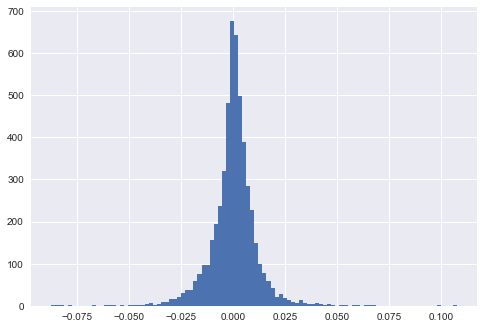

In [6]:
x = df["simple_daily_returns"]
plt.hist(x, bins = 100)
plt.show()

In [7]:
df= df[ ["simple_daily_returns"] + [ col for col in df.columns if col != "simple_daily_returns" ]]
df= df[ ["Y_next_daily_returns"] + [ col for col in df.columns if col != "Y_next_daily_returns" ]]

### 1.1.3. Adding station features <a class="anchor" id="113">

In [8]:
df['day-of-week'] = df.index.dayofweek
df['week-of-year'] = df.index.weekofyear
df['month-of-year'] = df.index.month

### 1.1.4. Calculating Day volatility in % <a class="anchor" id="114">

In [9]:
df["day_volatility_%"]=(df["High"]-df["Low"])/df["Low"]

In [10]:
df.head(3)

,Y_next_daily_returns,simple_daily_returns,Open,High,Low,Close,Volume,log_daily_returns,day-of-week,week-of-year,month-of-year,day_volatility_%
Date,,,,,,,,,,,,
2002-05-31,-0.024795,0.002329,1064.660034,1079.930054,1064.660034,1067.140015,1277300000,-0.002327,4,22,5,0.014343
2002-06-03,0.000010,-0.024795,1067.140015,1070.739990,1039.900024,1040.680054,1324300000,0.025108,0,23,6,0.029657
2002-06-04,0.008850,0.000010,1040.680054,1046.060059,1030.520020,1040.689941,1466600000,-0.000010,1,23,6,0.015080


## 1.2. Aggregating Macro-Factor returns  <a class="anchor" id="12">

Let's continue with the macro factors

### 1.2.1. Gold Price  <a class="anchor" id="121">

Gold oz can be traded at any hour. So open and close prices are just the price for a fixed time

In [11]:
gold_oz = yf.download("GC=F", start = start, end = end)
gold_oz["gold_returns"] = (gold_oz.Close - gold_oz.Open) / gold_oz.Open
df["gold_returns"]=gold_oz["gold_returns"]
df.head(4)

[*********************100%***********************]  1 of 1 completed


,Y_next_daily_returns,simple_daily_returns,Open,High,Low,Close,Volume,log_daily_returns,day-of-week,week-of-year,month-of-year,day_volatility_%,gold_returns
Date,,,,,,,,,,,,,
2002-05-31,-0.024795,0.002329,1064.660034,1079.930054,1064.660034,1067.140015,1277300000,-0.002327,4,22,5,0.014343,0.004615
2002-06-03,0.000010,-0.024795,1067.140015,1070.739990,1039.900024,1040.680054,1324300000,0.025108,0,23,6,0.029657,0.000306
2002-06-04,0.008850,0.000010,1040.680054,1046.060059,1030.520020,1040.689941,1466600000,-0.000010,1,23,6,0.015080,0.002446
2002-06-05,-0.019764,0.008850,1040.689941,1050.109985,1038.839966,1049.900024,1300100000,-0.008811,2,23,6,0.010849,-0.018637


## 1.2.2. Oil Price  <a class="anchor" id="122">

WTI can be traded at any hour. Because of that it is possible to get the information from open to open of next day

In [12]:
oil = yf.download("CL=F", start = start, end = end)
oil["oil_returns"] = (oil.Close - oil.Open) / oil.Open
df["oil_returns"] = oil["oil_returns"]
df.head(4)

[*********************100%***********************]  1 of 1 completed


,Y_next_daily_returns,simple_daily_returns,Open,High,Low,Close,Volume,log_daily_returns,day-of-week,week-of-year,month-of-year,day_volatility_%,gold_returns,oil_returns
Date,,,,,,,,,,,,,,
2002-05-31,-0.024795,0.002329,1064.660034,1079.930054,1064.660034,1067.140015,1277300000,-0.002327,4,22,5,0.014343,0.004615,0.018072
2002-06-03,0.000010,-0.024795,1067.140015,1070.739990,1039.900024,1040.680054,1324300000,0.025108,0,23,6,0.029657,0.000306,-0.005938
2002-06-04,0.008850,0.000010,1040.680054,1046.060059,1030.520020,1040.689941,1466600000,-0.000010,1,23,6,0.015080,0.002446,0.009980
2002-06-05,-0.019764,0.008850,1040.689941,1050.109985,1038.839966,1049.900024,1300100000,-0.008811,2,23,6,0.010849,-0.018637,0.003629


### 1.2.3. Yield Price - 13 weeks  <a class="anchor" id="123">

It is calculated the daily return for open/close price

### Sometimes this ticker is not available in yahoo finance

In [13]:
treasury_13w = yf.download("^IRX", start = start, end = end)
treasury_13w["13w_yield_returns"] = (treasury_13w.Close - treasury_13w.Open) / treasury_13w.Open
df["treasury_13w_returns"]=treasury_13w["13w_yield_returns"]
df.head(4)

[*********************100%***********************]  1 of 1 completed


,Y_next_daily_returns,simple_daily_returns,Open,High,Low,Close,Volume,log_daily_returns,day-of-week,week-of-year,month-of-year,day_volatility_%,gold_returns,oil_returns,treasury_13w_returns
Date,,,,,,,,,,,,,,,
2002-05-31,-0.024795,0.002329,1064.660034,1079.930054,1064.660034,1067.140015,1277300000,-0.002327,4,22,5,0.014343,0.004615,0.018072,-0.006989
2002-06-03,0.000010,-0.024795,1067.140015,1070.739990,1039.900024,1040.680054,1324300000,0.025108,0,23,6,0.029657,0.000306,-0.005938,0.007638
2002-06-04,0.008850,0.000010,1040.680054,1046.060059,1030.520020,1040.689941,1466600000,-0.000010,1,23,6,0.015080,0.002446,0.009980,0.004687
2002-06-05,-0.019764,0.008850,1040.689941,1050.109985,1038.839966,1049.900024,1300100000,-0.008811,2,23,6,0.010849,-0.018637,0.003629,-0.002323


It is necessary to get the information through other way as the yahoo API is not working

In [14]:
# In case the ticker is not available it is necessary to get from the dataset

#week_13_treasury = pd.read_csv('.\Data\IRX.csv')
#mask = (week_13_treasury["Date"]>=start) & (week_13_treasury["Date"]<=end)
#week_13_treasury = week_13_treasury.loc[mask]
#week_13_treasury["yield_returns"] = np.log(week_13_treasury.Open / week_13_treasury.Close)*100

In this case the date is a string and it is necessary to treat it in order
to standarize the timestamp

In [15]:
#dates_treasury = list(week_13_treasury["Date"])
#dates_treasury_return = list(week_13_treasury["yield_returns"])
#data=pd.DataFrame(columns = ['Date','Yield_returns'])

#for i in df.index:
#    for j in range(len(dates_treasury_return)):
#        #print(i)
#        #print(dates_treasury[j])
#        if dates_treasury[j] in str(i):
#            a=[i,dates_treasury_return[j]]
#            data.loc[len(data.index)] = a

In [16]:
#data.index = data["Date"]
#df["yield_returns"]=data["Yield_returns"]

### 1.2.4. Yield Price - 10 years <a class="anchor" id="124">

In [17]:
treasury_10y = yf.download("^TNX", start = start, end = end)
treasury_10y["treasury_10y_returns"] = (treasury_10y.Close - treasury_10y.Open) / treasury_10y.Open
df["treasury_10y_returns"]=treasury_10y["treasury_10y_returns"]
df.head(4)

[*********************100%***********************]  1 of 1 completed


,Y_next_daily_returns,simple_daily_returns,Open,High,Low,Close,Volume,log_daily_returns,day-of-week,week-of-year,month-of-year,day_volatility_%,gold_returns,oil_returns,treasury_13w_returns,treasury_10y_returns
Date,,,,,,,,,,,,,,,,
2002-05-31,-0.024795,0.002329,1064.660034,1079.930054,1064.660034,1067.140015,1277300000,-0.002327,4,22,5,0.014343,0.004615,0.018072,-0.006989,0.000794
2002-06-03,0.000010,-0.024795,1067.140015,1070.739990,1039.900024,1040.680054,1324300000,0.025108,0,23,6,0.029657,0.000306,-0.005938,0.007638,-0.007483
2002-06-04,0.008850,0.000010,1040.680054,1046.060059,1030.520020,1040.689941,1466600000,-0.000010,1,23,6,0.015080,0.002446,0.009980,0.004687,0.008045
2002-06-05,-0.019764,0.008850,1040.689941,1050.109985,1038.839966,1049.900024,1300100000,-0.008811,2,23,6,0.010849,-0.018637,0.003629,-0.002323,-0.000397


In [18]:
#datetime.timestamp(week_13_treasury_return.index[0])

In [19]:
#week_13_treasury_return.index[0]

### 1.2.5. Nasdaq <a class="anchor" id="125">

Return from open to close for Nasdaq

In [20]:
Nasdaq = yf.download("^IXIC", start = start, end = end)
Nasdaq["nasdaq_returns"] = (Nasdaq.Close - Nasdaq.Open) / Nasdaq.Open
df["nasdaq_returns"]=Nasdaq["nasdaq_returns"]

[*********************100%***********************]  1 of 1 completed


In [21]:
df.head(3)

,Y_next_daily_returns,simple_daily_returns,Open,High,Low,Close,Volume,log_daily_returns,day-of-week,week-of-year,month-of-year,day_volatility_%,gold_returns,oil_returns,treasury_13w_returns,treasury_10y_returns,nasdaq_returns
Date,,,,,,,,,,,,,,,,,
2002-05-31,-0.024795,0.002329,1064.660034,1079.930054,1064.660034,1067.140015,1277300000,-0.002327,4,22,5,0.014343,0.004615,0.018072,-0.006989,0.000794,-0.015459
2002-06-03,0.000010,-0.024795,1067.140015,1070.739990,1039.900024,1040.680054,1324300000,0.025108,0,23,6,0.029657,0.000306,-0.005938,0.007638,-0.007483,-0.031571
2002-06-04,0.008850,0.000010,1040.680054,1046.060059,1030.520020,1040.689941,1466600000,-0.000010,1,23,6,0.015080,0.002446,0.009980,0.004687,0.008045,0.012102


### 1.2.6. Dow Jones  <a class="anchor" id="126">

In [22]:
Dow_Jones = yf.download("^DJI", start = start, end = end)
Dow_Jones["Dow_Jones_returns"] = (Dow_Jones.Close - Dow_Jones.Open) / Dow_Jones.Open
df["dowJones_returns"]=Dow_Jones["Dow_Jones_returns"]

[*********************100%***********************]  1 of 1 completed


In [23]:
df.head(3)

,Y_next_daily_returns,simple_daily_returns,Open,High,Low,Close,Volume,log_daily_returns,day-of-week,week-of-year,month-of-year,day_volatility_%,gold_returns,oil_returns,treasury_13w_returns,treasury_10y_returns,nasdaq_returns,dowJones_returns
Date,,,,,,,,,,,,,,,,,,
2002-05-31,-0.024795,0.002329,1064.660034,1079.930054,1064.660034,1067.140015,1277300000,-0.002327,4,22,5,0.014343,0.004615,0.018072,-0.006989,0.000794,-0.015459,0.001019
2002-06-03,0.000010,-0.024795,1067.140015,1070.739990,1039.900024,1040.680054,1324300000,0.025108,0,23,6,0.029657,0.000306,-0.005938,0.007638,-0.007483,-0.031571,-0.021579
2002-06-04,0.008850,0.000010,1040.680054,1046.060059,1030.520020,1040.689941,1466600000,-0.000010,1,23,6,0.015080,0.002446,0.009980,0.004687,0.008045,0.012102,-0.002317


### 1.2.7. VIX  <a class="anchor" id="127">

In [24]:
VIX = yf.download("^VIX", start = start, end = end)
VIX["VIX_returns"] = (VIX.Close - VIX.Open) / VIX.Open
df["VIX_returns"]=VIX["VIX_returns"]

[*********************100%***********************]  1 of 1 completed


In [25]:
df.head(3)

,Y_next_daily_returns,simple_daily_returns,Open,High,Low,Close,Volume,log_daily_returns,day-of-week,week-of-year,month-of-year,day_volatility_%,gold_returns,oil_returns,treasury_13w_returns,treasury_10y_returns,nasdaq_returns,dowJones_returns,VIX_returns
Date,,,,,,,,,,,,,,,,,,,
2002-05-31,-0.024795,0.002329,1064.660034,1079.930054,1064.660034,1067.140015,1277300000,-0.002327,4,22,5,0.014343,0.004615,0.018072,-0.006989,0.000794,-0.015459,0.001019,-0.013820
2002-06-03,0.000010,-0.024795,1067.140015,1070.739990,1039.900024,1040.680054,1324300000,0.025108,0,23,6,0.029657,0.000306,-0.005938,0.007638,-0.007483,-0.031571,-0.021579,0.113918
2002-06-04,0.008850,0.000010,1040.680054,1046.060059,1030.520020,1040.689941,1466600000,-0.000010,1,23,6,0.015080,0.002446,0.009980,0.004687,0.008045,0.012102,-0.002317,0.012288


### 1.2.8. US POWER  <a class="anchor" id="128">

In [26]:
US = yf.download("DX-Y.NYB", start = start, end = end)
US["US_returns"] = (US.Close - US.Open) / US.Open
df["US_returns"]=US["US_returns"]

[*********************100%***********************]  1 of 1 completed


In [27]:
df.head(3)

,Y_next_daily_returns,simple_daily_returns,Open,High,Low,Close,Volume,log_daily_returns,day-of-week,week-of-year,month-of-year,day_volatility_%,gold_returns,oil_returns,treasury_13w_returns,treasury_10y_returns,nasdaq_returns,dowJones_returns,VIX_returns,US_returns
Date,,,,,,,,,,,,,,,,,,,,
2002-05-31,-0.024795,0.002329,1064.660034,1079.930054,1064.660034,1067.140015,1277300000,-0.002327,4,22,5,0.014343,0.004615,0.018072,-0.006989,0.000794,-0.015459,0.001019,-0.013820,0.004131
2002-06-03,0.000010,-0.024795,1067.140015,1070.739990,1039.900024,1040.680054,1324300000,0.025108,0,23,6,0.029657,0.000306,-0.005938,0.007638,-0.007483,-0.031571,-0.021579,0.113918,-0.005628
2002-06-04,0.008850,0.000010,1040.680054,1046.060059,1030.520020,1040.689941,1466600000,-0.000010,1,23,6,0.015080,0.002446,0.009980,0.004687,0.008045,0.012102,-0.002317,0.012288,0.002527


## 1.3. Data FRED  <a class="anchor" id="13">

#### fredapi is a Python API for the FRED data provided by the Federal Reserve Bank of St. Louis.

In [28]:
#pip install fredapi

In [29]:
from fredapi import Fred

**3.1. GDP      :** Gross Domestic Product.

**3.2. CPILFESL :** Consumer Price Index for All Urban Consumers.

**3.3. PCE      :** Personal Consumption Expenditures.

**3.4. UMCSENT  :** University of Michigan: Consumer Sentiment

**3.5. INDPRO   :** Industrial Production: Total Index

**3.6. IPMAN    :** Industrial Production: Manufacturing

In [30]:
#I want to go back 1 year to have all the aggregate date from the FED. It is because of the ffill
start0='2001-06-01'

In [31]:
index_fred = pd.date_range(start0,end,freq='d')

dates=index_fred

fred = Fred(api_key='8b123e8645dcf177d29291233cdf42e9')

data_add=["GDP","CPILFESL","PCE","UMCSENT","INDPRO","IPMAN"]

data_FRED = pd.DataFrame(index =dates, columns=data_add)

In [32]:
# Gross Domestic Product
for i in data_add:
    data = fred.get_series_latest_release(i)
    data = pd.DataFrame(data.loc[start0 : end])
    
    data_FRED[i]=data[data.keys()[0]].pct_change()

In [33]:
data_FRED.head(2)

,GDP,CPILFESL,PCE,UMCSENT,INDPRO,IPMAN
2001-06-01,NaN,NaN,NaN,NaN,NaN,NaN
2001-06-02,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
data_FRED.tail(2)

,GDP,CPILFESL,PCE,UMCSENT,INDPRO,IPMAN
2023-03-14,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-15,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
#All the NaN are filled witht he previos values
data_FRED.fillna(method = "ffill", inplace= True)

In [36]:
data_FRED.tail(2)

,GDP,CPILFESL,PCE,UMCSENT,INDPRO,IPMAN
2023-03-14,0.016367,0.004519,0.017617,0.087102,0.000003,0.001175
2023-03-15,0.016367,0.004519,0.017617,0.087102,0.000003,0.001175


In [37]:
data_FRED.head(2)

,GDP,CPILFESL,PCE,UMCSENT,INDPRO,IPMAN
2001-06-01,NaN,NaN,NaN,NaN,NaN,NaN
2001-06-02,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
#greater than the start date and smaller than the end date
mask = (data_FRED.index >= start) & (data_FRED.index<= end)
data_FRED = data_FRED.loc[mask]

In [39]:
data_FRED.head(2)

,GDP,CPILFESL,PCE,UMCSENT,INDPRO,IPMAN
2002-06-01,0.009641,0.001053,0.00461,-0.04644,0.008191,0.01017
2002-06-02,0.009641,0.001053,0.00461,-0.04644,0.008191,0.01017


In [40]:
#For those NaN where still there is NaN, it is possible to fill with the previos values.

#Other option is to remove these NaN's

#data_FRED.fillna(method = "bfill", inplace= True)

In [41]:
df = df.join(data_FRED)

## 1.4. Quantitative methods <a class="anchor" id="14">

Let's continue with the technical factors

In [42]:
df.head(5)

,Y_next_daily_returns,simple_daily_returns,Open,High,Low,Close,Volume,log_daily_returns,day-of-week,week-of-year,...,nasdaq_returns,dowJones_returns,VIX_returns,US_returns,GDP,CPILFESL,PCE,UMCSENT,INDPRO,IPMAN
Date,,,,,,,,,,,,,,,,,,,,,
2002-05-31,-0.024795,0.002329,1064.660034,1079.930054,1064.660034,1067.140015,1277300000,-0.002327,4,22,...,-0.015459,0.001019,-0.013820,0.004131,NaN,NaN,NaN,NaN,NaN,NaN
2002-06-03,0.000010,-0.024795,1067.140015,1070.739990,1039.900024,1040.680054,1324300000,0.025108,0,23,...,-0.031571,-0.021579,0.113918,-0.005628,0.009641,0.001053,0.00461,-0.04644,0.008191,0.01017
2002-06-04,0.008850,0.000010,1040.680054,1046.060059,1030.520020,1040.689941,1466600000,-0.000010,1,23,...,0.012102,-0.002317,0.012288,0.002527,0.009641,0.001053,0.00461,-0.04644,0.008191,0.01017
2002-06-05,-0.019764,0.008850,1040.689941,1050.109985,1038.839966,1049.900024,1300100000,-0.008811,2,23,...,0.009620,0.011175,-0.038690,0.000719,0.009641,0.001053,0.00461,-0.04644,0.008191,0.01017
2002-06-06,-0.001574,-0.019764,1049.900024,1049.900024,1026.910034,1029.150024,1601500000,0.019962,3,23,...,-0.018167,-0.017463,0.051807,-0.008233,0.009641,0.001053,0.00461,-0.04644,0.008191,0.01017


In [43]:
df.tail(5)

,Y_next_daily_returns,simple_daily_returns,Open,High,Low,Close,Volume,log_daily_returns,day-of-week,week-of-year,...,nasdaq_returns,dowJones_returns,VIX_returns,US_returns,GDP,CPILFESL,PCE,UMCSENT,INDPRO,IPMAN
Date,,,,,,,,,,,,,,,,,,,,,
2023-03-08,-0.020092,0.001118,3987.550049,4000.409912,3969.760010,3992.010010,3535570000,-0.001118,2,10,...,0.001983,-0.002241,-0.030441,-0.000095,0.016367,0.004519,0.017617,0.087102,0.000003,0.001175
2023-03-09,-0.013080,-0.020092,3998.659912,4017.810059,3908.699951,3918.320068,4445260000,0.020296,3,10,...,-0.020725,-0.018918,0.169684,-0.002935,0.016367,0.004519,0.017617,0.087102,0.000003,0.001175
2023-03-10,0.005382,-0.013080,3912.770020,3934.050049,3846.320068,3861.590088,5518190000,0.013167,4,10,...,-0.016465,-0.008560,0.062554,-0.005232,0.016367,0.004519,0.017617,0.087102,0.000003,0.001175
2023-03-13,0.006492,0.005382,3835.120117,3905.050049,3808.860107,3855.760010,6558020000,-0.005367,0,11,...,0.013348,-0.000025,0.102703,-0.007568,0.016367,0.004519,0.017617,0.087102,0.000003,0.001175
2023-03-14,NaN,0.006492,3894.010010,3937.290039,3873.629883,3919.290039,5665870000,-0.006471,1,11,...,0.006200,0.003123,-0.116201,-0.000675,0.016367,0.004519,0.017617,0.087102,0.000003,0.001175


### 1.4.1. MACD <a class="anchor" id="141">

In [44]:
EMA_S=12
EMA_L=26
signal_mw=9

df["EMA_S"] = df["Close"].ewm(span = EMA_S, min_periods = EMA_S).mean() 
df["EMA_L"] = df["Close"].ewm(span = EMA_L, min_periods = EMA_L).mean()
df["MACD"] = df.EMA_S - df.EMA_L
df["MACD_Signal"] = df.MACD.ewm(span = signal_mw, min_periods = signal_mw).mean()

In [45]:
df.drop(["EMA_S","EMA_L","MACD"],1,inplace=True)

### 1.4.2. RSI <a class="anchor" id="142">

In [46]:
periods=14

#df.columns = ["price"]

#df["returns"] = np.log(df / df.shift(1))
df["U"] = np.where(df.Close.diff() > 0, df.Close.diff(), 0) 
df["D"] = np.where(df.Close.diff() < 0, -df.Close.diff(), 0)
df["MA_U"] = df.U.rolling(periods).mean()
df["MA_D"] = df.D.rolling(periods).mean()
df["RSI"] = df.MA_U / (df.MA_U + df.MA_D) * 100

In [47]:
df.drop(["U","D","MA_U","MA_D"],1,inplace=True)

### 1.4.3. ATR <a class="anchor" id="143">

In [48]:
high_low = df['High'] - df['Low']
high_close = np.abs(df['High'] - df['Close'].shift())
low_close = np.abs(df['Low'] - df['Close'].shift())

In [49]:
ranges = pd.concat([high_low, high_close, low_close], axis=1)
true_range = np.max(ranges, axis=1)
atr = true_range.rolling(14).sum()/14

In [50]:
df["atr"]=atr

In [51]:
df

,Y_next_daily_returns,simple_daily_returns,Open,High,Low,Close,Volume,log_daily_returns,day-of-week,week-of-year,...,US_returns,GDP,CPILFESL,PCE,UMCSENT,INDPRO,IPMAN,MACD_Signal,RSI,atr
Date,,,,,,,,,,,,,,,,,,,,,
2002-05-31,-0.024795,0.002329,1064.660034,1079.930054,1064.660034,1067.140015,1277300000,-0.002327,4,22,...,0.004131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-06-03,0.000010,-0.024795,1067.140015,1070.739990,1039.900024,1040.680054,1324300000,0.025108,0,23,...,-0.005628,0.009641,0.001053,0.004610,-0.046440,0.008191,0.010170,NaN,NaN,NaN
2002-06-04,0.008850,0.000010,1040.680054,1046.060059,1030.520020,1040.689941,1466600000,-0.000010,1,23,...,0.002527,0.009641,0.001053,0.004610,-0.046440,0.008191,0.010170,NaN,NaN,NaN
2002-06-05,-0.019764,0.008850,1040.689941,1050.109985,1038.839966,1049.900024,1300100000,-0.008811,2,23,...,0.000719,0.009641,0.001053,0.004610,-0.046440,0.008191,0.010170,NaN,NaN,NaN
2002-06-06,-0.001574,-0.019764,1049.900024,1049.900024,1026.910034,1029.150024,1601500000,0.019962,3,23,...,-0.008233,0.009641,0.001053,0.004610,-0.046440,0.008191,0.010170,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-08,-0.020092,0.001118,3987.550049,4000.409912,3969.760010,3992.010010,3535570000,-0.001118,2,10,...,-0.000095,0.016367,0.004519,0.017617,0.087102,0.000003,0.001175,-3.382216,31.818060,51.881452
2023-03-09,-0.013080,-0.020092,3998.659912,4017.810059,3908.699951,3918.320068,4445260000,0.020296,3,10,...,-0.002935,0.016367,0.004519,0.017617,0.087102,0.000003,0.001175,-6.145938,30.636633,55.524309
2023-03-10,0.005382,-0.013080,3912.770020,3934.050049,3846.320068,3861.590088,5518190000,0.013167,4,10,...,-0.005232,0.016367,0.004519,0.017617,0.087102,0.000003,0.001175,-10.271880,27.796144,58.757882


## 1.5. Data Quality checks <a class="anchor" id="15">

In [52]:
df.isna().sum().sum()

110

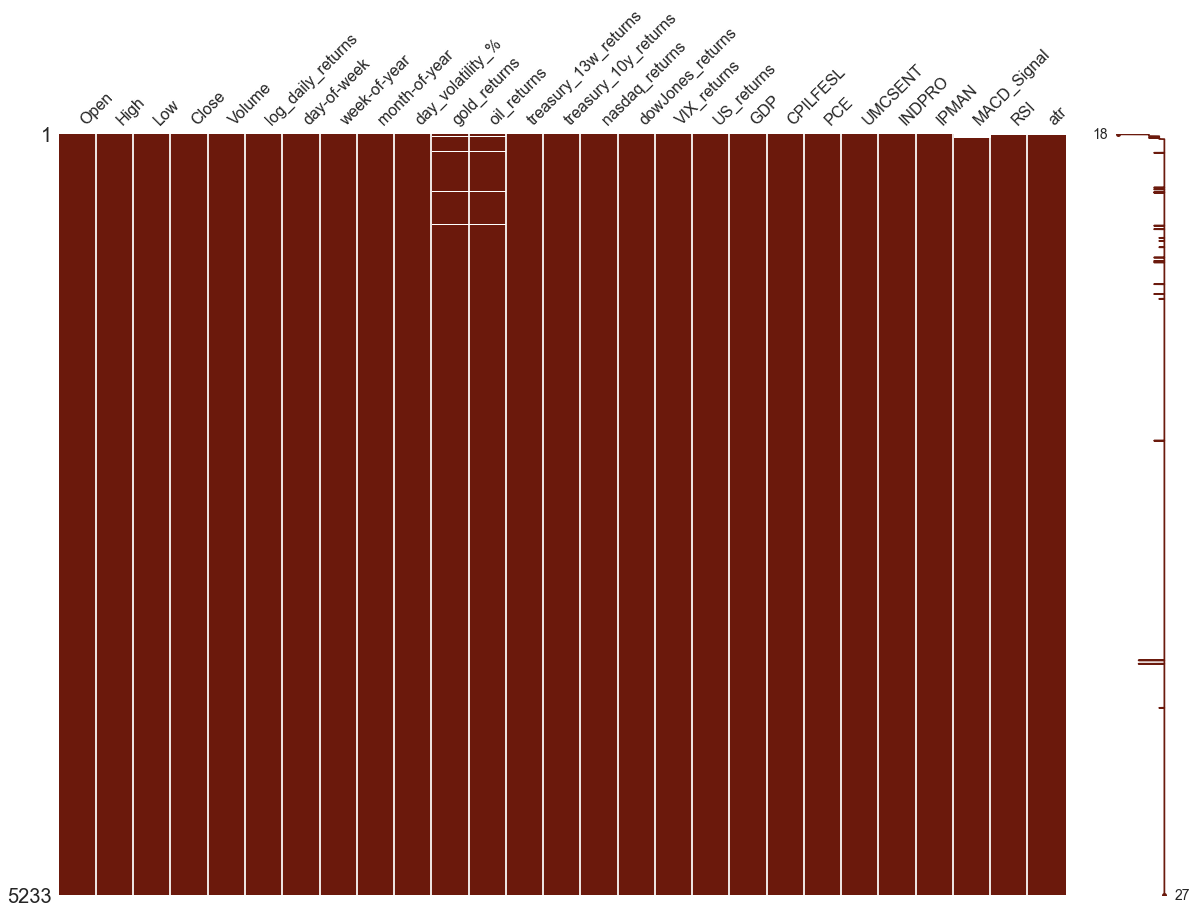

In [53]:
import missingno as msno
# Nullity or missing values by columns
msno.matrix(df=df.iloc[:,2:len(df.columns)], figsize=(20, 14), color=(0.42, 0.1, 0.05))

In [54]:
df.fillna(method='ffill', inplace=True)

In [55]:
print("Number of Not At Number: ",df.isna().sum().sum())

Number of Not At Number:  65


In [57]:
df = df.dropna()

In [58]:
print("Number of Not At Number: ",df.isna().sum().sum())

Number of Not At Number:  0


## 1.6. Saving Data Set <a class="anchor" id="16">

In [60]:
from datetime import datetime
from datetime import date
dt = datetime.today()

In [61]:
name = 'DF_CURATED_' + str(dt.year)+'_'+str(dt.month)+'_'+str(dt.day)+'_'+str(dt.hour)+ ".csv"

In [62]:
save_name = './DATA_CURATED/'+ name

In [63]:
save_name

'./DATA_CURATED/DF_CURATED_2023_3_22_21.csv'

In [64]:
df.to_csv(save_name, encoding='utf-8')

In [65]:
keys = pd.DataFrame()

In [66]:
keys["keys"] = pd.DataFrame(df.keys())

In [67]:
keys.head(2)

,keys
0,Y_next_daily_returns
1,simple_daily_returns


In [68]:
keys.to_csv(save_name[0:len(save_name)-4] + '_keys.csv', encoding='utf-8')

In [69]:
df

,Y_next_daily_returns,simple_daily_returns,Open,High,Low,Close,Volume,log_daily_returns,day-of-week,week-of-year,...,US_returns,GDP,CPILFESL,PCE,UMCSENT,INDPRO,IPMAN,MACD_Signal,RSI,atr
Date,,,,,,,,,,,,,,,,,,,,,
2002-07-18,-0.038352,-0.026385,905.450012,907.799988,880.599976,881.559998,1736300000,0.026739,3,29,...,-0.000765,0.008871,0.001577,0.008849,-0.046537,-0.000229,-0.001066,-20.428083,24.627836,26.907863
2002-07-19,-0.032922,-0.038352,881.559998,881.559998,842.070007,847.750000,2654100000,0.039107,4,29,...,0.002408,0.008871,0.001577,0.008849,-0.046537,-0.000229,-0.001066,-22.343688,21.351079,28.765721
2002-07-22,-0.027017,-0.032922,847.760010,854.130005,813.260010,819.849976,2248060000,0.033476,0,30,...,0.003929,0.008871,0.001577,0.008849,-0.046537,-0.000229,-0.001066,-24.872814,20.786866,29.754290
2002-07-23,0.057314,-0.027017,819.849976,827.690002,796.130005,797.700012,2441020000,0.027389,1,30,...,0.007462,0.008871,0.001577,0.008849,-0.046537,-0.000229,-0.001066,-27.915234,20.657899,30.357858
2002-07-24,-0.005620,0.057314,797.710022,844.320007,775.679993,843.429993,2775560000,-0.055732,2,30,...,-0.007244,0.008871,0.001577,0.008849,-0.046537,-0.000229,-0.001066,-30.291201,31.330634,33.872859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-07,0.001118,-0.015288,4048.260010,4050.000000,3980.310059,3986.370117,3922500000,0.015406,1,10,...,0.012656,0.016367,0.004519,0.017617,0.087102,0.000003,0.001175,-1.601315,32.734644,52.844308
2023-03-08,-0.020092,0.001118,3987.550049,4000.409912,3969.760010,3992.010010,3535570000,-0.001118,2,10,...,-0.000095,0.016367,0.004519,0.017617,0.087102,0.000003,0.001175,-3.382216,31.818060,51.881452
2023-03-09,-0.013080,-0.020092,3998.659912,4017.810059,3908.699951,3918.320068,4445260000,0.020296,3,10,...,-0.002935,0.016367,0.004519,0.017617,0.087102,0.000003,0.001175,-6.145938,30.636633,55.524309


# PART 2: Transformin the returns to binary.  

### 0 : Downtrend

### 1: Uptrend

## 2. Transforming to 2_Class-Binary Problem <a class="anchor" id="2">

In [70]:
save_name

'./DATA_CURATED/DF_CURATED_2023_3_22_21.csv'

In [71]:
df = pd.read_csv(save_name)

In [72]:
df = df.dropna()

In [73]:
df.index = df["Date"]

In [74]:
df.drop(["Date"],1,inplace=True)

In [75]:
df.shape

(5178, 29)

In [76]:
df.head(5)

,Y_next_daily_returns,simple_daily_returns,Open,High,Low,Close,Volume,log_daily_returns,day-of-week,week-of-year,...,US_returns,GDP,CPILFESL,PCE,UMCSENT,INDPRO,IPMAN,MACD_Signal,RSI,atr
Date,,,,,,,,,,,,,,,,,,,,,
2002-07-18,-0.038352,-0.026385,905.450012,907.799988,880.599976,881.559998,1736300000,0.026739,3,29,...,-0.000765,0.008871,0.001577,0.008849,-0.046537,-0.000229,-0.001066,-20.428083,24.627836,26.907863
2002-07-19,-0.032922,-0.038352,881.559998,881.559998,842.070007,847.750000,2654100000,0.039107,4,29,...,0.002408,0.008871,0.001577,0.008849,-0.046537,-0.000229,-0.001066,-22.343688,21.351079,28.765721
2002-07-22,-0.027017,-0.032922,847.760010,854.130005,813.260010,819.849976,2248060000,0.033476,0,30,...,0.003929,0.008871,0.001577,0.008849,-0.046537,-0.000229,-0.001066,-24.872814,20.786866,29.754290
2002-07-23,0.057314,-0.027017,819.849976,827.690002,796.130005,797.700012,2441020000,0.027389,1,30,...,0.007462,0.008871,0.001577,0.008849,-0.046537,-0.000229,-0.001066,-27.915234,20.657899,30.357858
2002-07-24,-0.005620,0.057314,797.710022,844.320007,775.679993,843.429993,2775560000,-0.055732,2,30,...,-0.007244,0.008871,0.001577,0.008849,-0.046537,-0.000229,-0.001066,-30.291201,31.330634,33.872859


#### The goal is to transform the data set to 0 or 1. 

    * 0 == down
    
    * 1 == up

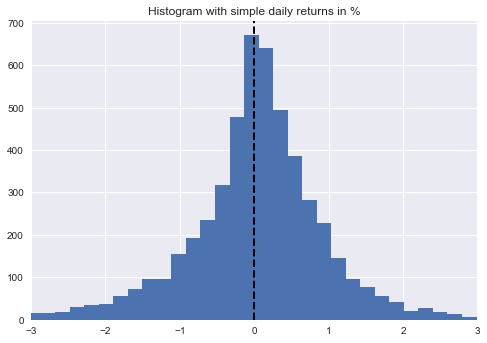

In [77]:
plt.hist(df["Y_next_daily_returns"]*100, bins=100)
plt.title("Histogram with simple daily returns in %")
plt.axvline(0, color='k', linestyle='--', linewidth=2)
plt.xlim([-3, 3])
plt.show()

#### Labelling classes

In [78]:
label=[]
for i in range(len(df["Y_next_daily_returns"])):

    if df["Y_next_daily_returns"][i]<=0:
        
        label.append(0)
        
    elif df["Y_next_daily_returns"][i]>0:
    
        label.append(1)

In [79]:
#Testing that all the returns are classified correctly
my_list = list(set(label))

In [80]:
df["Y_label"]=label
df= df[ ["Y_label"] + [ col for col in df.columns if col != "Y_label" ]]

In [81]:
df.head(10)

,Y_label,Y_next_daily_returns,simple_daily_returns,Open,High,Low,Close,Volume,log_daily_returns,day-of-week,...,US_returns,GDP,CPILFESL,PCE,UMCSENT,INDPRO,IPMAN,MACD_Signal,RSI,atr
Date,,,,,,,,,,,,,,,,,,,,,
2002-07-18,0,-0.038352,-0.026385,905.450012,907.799988,880.599976,881.559998,1736300000,0.026739,3,...,-0.000765,0.008871,0.001577,0.008849,-0.046537,-0.000229,-0.001066,-20.428083,24.627836,26.907863
2002-07-19,0,-0.032922,-0.038352,881.559998,881.559998,842.070007,847.750000,2654100000,0.039107,4,...,0.002408,0.008871,0.001577,0.008849,-0.046537,-0.000229,-0.001066,-22.343688,21.351079,28.765721
2002-07-22,0,-0.027017,-0.032922,847.760010,854.130005,813.260010,819.849976,2248060000,0.033476,0,...,0.003929,0.008871,0.001577,0.008849,-0.046537,-0.000229,-0.001066,-24.872814,20.786866,29.754290
2002-07-23,1,0.057314,-0.027017,819.849976,827.690002,796.130005,797.700012,2441020000,0.027389,1,...,0.007462,0.008871,0.001577,0.008849,-0.046537,-0.000229,-0.001066,-27.915234,20.657899,30.357858
2002-07-24,0,-0.005620,0.057314,797.710022,844.320007,775.679993,843.429993,2775560000,-0.055732,2,...,-0.007244,0.008871,0.001577,0.008849,-0.046537,-0.000229,-0.001066,-30.291201,31.330634,33.872859
2002-07-25,1,0.016884,-0.005620,843.419983,853.830017,816.109985,838.679993,2424700000,0.005636,3,...,-0.001615,0.008871,0.001577,0.008849,-0.046537,-0.000229,-0.001066,-32.141147,21.718514,34.061432
2002-07-26,1,0.054078,0.016884,838.679993,852.849976,835.919983,852.840027,1796100000,-0.016743,4,...,0.012152,0.008871,0.001577,0.008849,-0.046537,-0.000229,-0.001066,-33.272124,26.832644,33.795715
2002-07-29,1,0.004249,0.054078,852.840027,898.960022,852.840027,898.960022,1778650000,-0.052667,0,...,0.003749,0.008871,0.001577,0.008849,-0.046537,-0.000229,-0.001066,-33.098415,40.708546,35.095716
2002-07-30,1,0.009792,0.004249,898.960022,909.809998,884.700012,902.780029,1826090000,-0.004240,1,...,-0.003545,0.008871,0.001577,0.008849,-0.046537,-0.000229,-0.001066,-31.997111,46.615660,34.314283


In [82]:
df.tail(10)

,Y_label,Y_next_daily_returns,simple_daily_returns,Open,High,Low,Close,Volume,log_daily_returns,day-of-week,...,US_returns,GDP,CPILFESL,PCE,UMCSENT,INDPRO,IPMAN,MACD_Signal,RSI,atr
Date,,,,,,,,,,,,,,,,,,,,,
2023-02-28,0,-0.003015,-0.001770,3977.189941,3997.500000,3968.979980,3970.149902,5043400000,0.001772,1,...,0.002294,0.016367,0.004519,0.017617,0.087102,0.000003,0.001175,15.910786,25.481289,54.257900
2023-03-01,1,0.010834,-0.003015,3963.340088,3971.729980,3939.050049,3951.389893,4249480000,0.003020,2,...,-0.005331,0.016367,0.004519,0.017617,0.087102,0.000003,0.001175,10.236096,27.377520,52.854318
2023-03-02,1,0.011911,0.010834,3938.679932,3990.840088,3928.159912,3981.350098,4244900000,-0.010775,3,...,0.006131,0.016367,0.004519,0.017617,0.087102,0.000003,0.001175,5.330029,36.149187,51.148612
2023-03-03,0,-0.001660,0.011911,3998.020020,4048.290039,3995.169922,4045.639893,4084730000,-0.011840,4,...,-0.004002,0.016367,0.004519,0.017617,0.087102,0.000003,0.001175,2.176462,44.624094,53.532174
2023-03-06,0,-0.015288,-0.001660,4055.149902,4078.489990,4044.610107,4048.419922,4000870000,0.001661,0,...,-0.001722,0.016367,0.004519,0.017617,0.087102,0.000003,0.001175,0.326036,38.081062,52.492170
2023-03-07,1,0.001118,-0.015288,4048.260010,4050.000000,3980.310059,3986.370117,3922500000,0.015406,1,...,0.012656,0.016367,0.004519,0.017617,0.087102,0.000003,0.001175,-1.601315,32.734644,52.844308
2023-03-08,0,-0.020092,0.001118,3987.550049,4000.409912,3969.760010,3992.010010,3535570000,-0.001118,2,...,-0.000095,0.016367,0.004519,0.017617,0.087102,0.000003,0.001175,-3.382216,31.818060,51.881452
2023-03-09,0,-0.013080,-0.020092,3998.659912,4017.810059,3908.699951,3918.320068,4445260000,0.020296,3,...,-0.002935,0.016367,0.004519,0.017617,0.087102,0.000003,0.001175,-6.145938,30.636633,55.524309
2023-03-10,1,0.005382,-0.013080,3912.770020,3934.050049,3846.320068,3861.590088,5518190000,0.013167,4,...,-0.005232,0.016367,0.004519,0.017617,0.087102,0.000003,0.001175,-10.271880,27.796144,58.757882


In [83]:
name = "2_CLASS_" +name

In [84]:
name

'2_CLASS_DF_CURATED_2023_3_22_21.csv'

In [85]:
path = "./Data_Transformed_2_Class/"

In [86]:
save_name = path + name

In [87]:
save_name

'./Data_Transformed_2_Class/2_CLASS_DF_CURATED_2023_3_22_21.csv'

In [88]:
df.to_csv(save_name, encoding='utf-8')

# PART 3:

# 3. Models <a class="anchor" id="3">

## 3.0. Libraries <a class="anchor" id="30">

In [89]:
plt.rcParams['figure.figsize'] =(20,10)
plt.style.use('fivethirtyeight')

# # Sklearn
# import sklearn
# # Preprocessor from sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
# Feature importance
from sklearn.ensemble import ExtraTreesClassifier

# Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

# from tensorflow.keras import Input
# from tensorflow.keras.layers import Dense, LSTM
# from tensorflow.keras.models import load_model, Model

# Model Metrics
from sklearn.metrics import accuracy_score

# ROC Curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


from sklearn.metrics import confusion_matrix
# Resample
# Block Bootstrap
#from arch.bootstrap import StationaryBootstrap
# Time Series cross-validation
#from sklearn.model_selection import TimeSeriesSplit

# Class encoder
#from sklearn.preprocessing import LabelEncoder 


## 3.1. Loading Data <a class="anchor" id="31">

In [90]:
path = "C:\\Users\\pcalatayud\\Desktop\\jupyter\\TFM_2\\Data_Transformed_2_Class\\"

In [91]:
file = path + name
file

'C:\\Users\\pcalatayud\\Desktop\\jupyter\\TFM_2\\Data_Transformed_2_Class\\2_CLASS_DF_CURATED_2023_3_22_21.csv'

In [92]:
path = "C:\\Users\\pcalatayud\\Desktop\\jupyter\\TFM\\ML\\Transformation\\Data_Transformed_2_Class\\"
name = "2_CLASS_DF_CURATED_2022_12_7_11.csv"

file = path + name
file

'C:\\Users\\pcalatayud\\Desktop\\jupyter\\TFM\\ML\\Transformation\\Data_Transformed_2_Class\\2_CLASS_DF_CURATED_2022_12_7_11.csv'

In [93]:
df = pd.read_csv(file, index_col=0)

In [94]:
df.head(3)

,Y_label,Y_next_daily_returns,simple_daily_returns,Close,Volume,log_daily_returns,day-of-week,week-of-year,month-of-year,day_volatility_%,...,VIX_returns,US_returns,GDP,CPILFESL,PCE,UMCSENT,INDPRO,IPMAN,MACD_Signal,RSI
Date,,,,,,,,,,,,,,,,,,,,,
2002-07-18,0,-0.038352,-0.026385,881.559998,1736300000,0.026739,3,29,7,0.030888,...,-0.002273,-0.000765,0.008871,0.001577,0.008849,-0.046537,-0.000229,-0.001066,-20.428083,24.627836
2002-07-19,0,-0.032922,-0.038352,847.750000,2654100000,0.039107,4,29,7,0.046896,...,0.048051,0.002408,0.008871,0.001577,0.008849,-0.046537,-0.000229,-0.001066,-22.343688,21.351079
2002-07-22,0,-0.027017,-0.032922,819.849976,2248060000,0.033476,0,30,7,0.050255,...,0.070023,0.003929,0.008871,0.001577,0.008849,-0.046537,-0.000229,-0.001066,-24.872814,20.786866


In [95]:
df.keys()

Index(['Y_label', 'Y_next_daily_returns', 'simple_daily_returns', 'Close',
       'Volume', 'log_daily_returns', 'day-of-week', 'week-of-year',
       'month-of-year', 'day_volatility_%', 'gold_returns', 'oil_returns',
       'treasury_13w_returns', 'treasury_10y_returns', 'nasdaq_returns',
       'dowJones_returns', 'VIX_returns', 'US_returns', 'GDP', 'CPILFESL',
       'PCE', 'UMCSENT', 'INDPRO', 'IPMAN', 'MACD_Signal', 'RSI'],
      dtype='object')

In [96]:
df.iloc[0:10,0:6]

,Y_label,Y_next_daily_returns,simple_daily_returns,Close,Volume,log_daily_returns
Date,,,,,,
2002-07-18,0,-0.038352,-0.026385,881.559998,1736300000,0.026739
2002-07-19,0,-0.032922,-0.038352,847.750000,2654100000,0.039107
2002-07-22,0,-0.027017,-0.032922,819.849976,2248060000,0.033476
2002-07-23,1,0.057314,-0.027017,797.700012,2441020000,0.027389
2002-07-24,0,-0.005620,0.057314,843.429993,2775560000,-0.055732
2002-07-25,1,0.016884,-0.005620,838.679993,2424700000,0.005636
2002-07-26,1,0.054078,0.016884,852.840027,1796100000,-0.016743
2002-07-29,1,0.004249,0.054078,898.960022,1778650000,-0.052667
2002-07-30,1,0.009792,0.004249,902.780029,1826090000,-0.004240


In [97]:
#Saving data for the metrics
performance=pd.DataFrame()
performance["Y_real"] = df["Y_label"]
performance["returns_real_open_close"] = df["Y_next_daily_returns"]
performance["return_real_day"] = df.Close.pct_change()
performance.head(3)

,Y_real,returns_real_open_close,return_real_day
Date,,,
2002-07-18,0,-0.038352,NaN
2002-07-19,0,-0.032922,-0.038352
2002-07-22,0,-0.027017,-0.032911


## 3.2. Splitting data in training and test <a class="anchor" id="32">

In [98]:
X = df.copy()

In [99]:
X.head(4)

,Y_label,Y_next_daily_returns,simple_daily_returns,Close,Volume,log_daily_returns,day-of-week,week-of-year,month-of-year,day_volatility_%,...,VIX_returns,US_returns,GDP,CPILFESL,PCE,UMCSENT,INDPRO,IPMAN,MACD_Signal,RSI
Date,,,,,,,,,,,,,,,,,,,,,
2002-07-18,0,-0.038352,-0.026385,881.559998,1736300000,0.026739,3,29,7,0.030888,...,-0.002273,-0.000765,0.008871,0.001577,0.008849,-0.046537,-0.000229,-0.001066,-20.428083,24.627836
2002-07-19,0,-0.032922,-0.038352,847.750000,2654100000,0.039107,4,29,7,0.046896,...,0.048051,0.002408,0.008871,0.001577,0.008849,-0.046537,-0.000229,-0.001066,-22.343688,21.351079
2002-07-22,0,-0.027017,-0.032922,819.849976,2248060000,0.033476,0,30,7,0.050255,...,0.070023,0.003929,0.008871,0.001577,0.008849,-0.046537,-0.000229,-0.001066,-24.872814,20.786866
2002-07-23,1,0.057314,-0.027017,797.700012,2441020000,0.027389,1,30,7,0.039642,...,0.062692,0.007462,0.008871,0.001577,0.008849,-0.046537,-0.000229,-0.001066,-27.915234,20.657899


In [100]:
X.drop(["Y_label","Y_next_daily_returns"],1,inplace=True)

In [101]:
X.head(4)

,simple_daily_returns,Close,Volume,log_daily_returns,day-of-week,week-of-year,month-of-year,day_volatility_%,gold_returns,oil_returns,...,VIX_returns,US_returns,GDP,CPILFESL,PCE,UMCSENT,INDPRO,IPMAN,MACD_Signal,RSI
Date,,,,,,,,,,,,,,,,,,,,,
2002-07-18,-0.026385,881.559998,1736300000,0.026739,3,29,7,0.030888,0.0,-0.005411,...,-0.002273,-0.000765,0.008871,0.001577,0.008849,-0.046537,-0.000229,-0.001066,-20.428083,24.627836
2002-07-19,-0.038352,847.750000,2654100000,0.039107,4,29,7,0.046896,0.0,0.021284,...,0.048051,0.002408,0.008871,0.001577,0.008849,-0.046537,-0.000229,-0.001066,-22.343688,21.351079
2002-07-22,-0.032922,819.849976,2248060000,0.033476,0,30,7,0.050255,0.0,-0.022777,...,0.070023,0.003929,0.008871,0.001577,0.008849,-0.046537,-0.000229,-0.001066,-24.872814,20.786866
2002-07-23,-0.027017,797.700012,2441020000,0.027389,1,30,7,0.039642,0.0,-0.017183,...,0.062692,0.007462,0.008871,0.001577,0.008849,-0.046537,-0.000229,-0.001066,-27.915234,20.657899


In [102]:
# 70% train/test split
split = int(len(X) * split)
Y=performance.Y_real
# We transform Y to a binary classification problem's values (0 y 1)
from sklearn.preprocessing import LabelEncoder 
encoder = LabelEncoder() 
encoder.fit(Y) 
encoded_Y = encoder.transform(Y) 
# We transform encoded_Y into a dataframe in order to use .iloc and being able to make the train/test split
Y = pd.DataFrame(encoded_Y, columns = ['Column_A'],index=Y.index) 

# Create train data set
# We have to twist the dataset
X_train, y_train = X[:split], Y[:split]
# Test data after train split
# PARA EVITAR CORRELACION ENTRE LAS SERIES PODEMOS TOMAR [SPLIT+3:] ie QUE PREDIGA 3 DIAS ADELANTE DEL TRAIN SET
X_test, y_test = X[split:], Y[split:]

x_test_original=X_test
y_test_original=y_test
# Scale the features MinMax for training and test datasets
scaler = MinMaxScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)
# We change from array to dataframe
X_train=pd.DataFrame(scaled_X_train,columns=X.columns,index=X.iloc[:split].index)
y_train=pd.DataFrame(y_train,columns=Y.columns,index=Y[:split].index)
X_test=pd.DataFrame(scaled_X_test,columns=X.columns,index=X[split:].index)
y_test=pd.DataFrame(y_test,columns=Y.columns,index=Y[split:].index)

## 3.3. Machine Learning Models <a class="anchor" id="33">

In [103]:
runtimes=[]

### 3.3.1. Naive Bayes  <a class="anchor" id="331">

In [104]:
mnb = MultinomialNB()

start_mnb = time.time()
mnb.fit(X_train, y_train)
end_mnb = time.time()
mnb_runtime=end_mnb - start_mnb
runtimes.append(mnb_runtime)

print('Runtime:',mnb_runtime)
print("score on test: %.3f"  %mnb.score(X_test, y_test))
print("score on train: %.3f" %mnb.score(X_train, y_train))

Runtime: 0.003993988037109375
score on test: 0.544
score on train: 0.543


In [105]:
coef=list(mnb.fit(X_train, y_train).feature_log_prob_[0])

max_coef_index=list(np.argsort(coef)[::-1])
for i in max_coef_index:
    print(list(X_train.columns)[i]+' --> %.3f' %coef[i])

INDPRO --> -2.746
MACD_Signal --> -2.793
GDP --> -2.860
IPMAN --> -2.866
PCE --> -2.897
treasury_10y_returns --> -2.965
CPILFESL --> -3.017
UMCSENT --> -3.048
US_returns --> -3.104
log_daily_returns --> -3.130
nasdaq_returns --> -3.140
day-of-week --> -3.160
RSI --> -3.165
month-of-year --> -3.174
week-of-year --> -3.195
Close --> -3.218
gold_returns --> -3.263
simple_daily_returns --> -3.279
oil_returns --> -3.298
dowJones_returns --> -3.351
VIX_returns --> -3.629
Volume --> -3.825
treasury_13w_returns --> -4.339
day_volatility_% --> -4.764


### 3.3.2. Logistic Regression <a class="anchor" id="332">

In [106]:
lr=LogisticRegression(max_iter=1000)

start_lr = time.time()
lr.fit(X_train, y_train)
end_lr = time.time()
lr_runtime=end_lr - start_lr
runtimes.append(lr_runtime)

print('Runtime:',lr_runtime)
print("score on test: %.3f" % lr.score(X_test, y_test))
print("score on train: %.3f" % lr.score(X_train, y_train))

Runtime: 0.08199930191040039
score on test: 0.517
score on train: 0.560


In [107]:
coef=list(lr.fit(X_train, y_train).coef_[0])
max_coef_index=list(np.argsort(coef)[::-1])
for i in max_coef_index:
    print(list(X_train.columns)[i]+' --> %.3f' %coef[i])

GDP --> 0.695
IPMAN --> 0.678
PCE --> 0.473
UMCSENT --> 0.471
Volume --> 0.463
log_daily_returns --> 0.457
treasury_10y_returns --> 0.246
month-of-year --> 0.185
day_volatility_% --> 0.063
US_returns --> -0.027
day-of-week --> -0.080
Close --> -0.129
VIX_returns --> -0.138
treasury_13w_returns --> -0.142
nasdaq_returns --> -0.178
week-of-year --> -0.197
RSI --> -0.234
gold_returns --> -0.234
oil_returns --> -0.251
dowJones_returns --> -0.381
simple_daily_returns --> -0.445
CPILFESL --> -0.461
MACD_Signal --> -0.472
INDPRO --> -0.899


### 3.3.3. K-nearest Neighbours <a class="anchor" id="333">

In [108]:
knn = KNeighborsClassifier(n_neighbors=3)

start_knn = time.time()
knn.fit(X_train, y_train)
end_knn = time.time()
knn_runtime=end_knn - start_knn
runtimes.append(knn_runtime)

print('Runtime:',knn_runtime)
print("score on test: %.3f" % knn.score(X_test, y_test))
print("score on train: %.3f" % knn.score(X_train, y_train))

Runtime: 0.0050203800201416016
score on test: 0.472
score on train: 0.753


### 3.3.4. Support Vector Machine (SVM) <a class="anchor" id="334">

In [109]:
svm=LinearSVC(C=100)

start_svm = time.time()
svm.fit(X_train, y_train)
end_svm = time.time()
svm_runtime=end_svm - start_svm
runtimes.append(svm_runtime)

print('Runtime:',svm_runtime)
print("score on test: %.3f" % svm.score(X_test, y_test))
print("score on train: %.3f" % svm.score(X_train, y_train))

Runtime: 0.3470022678375244
score on test: 0.549
score on train: 0.544


In [110]:
coef=list(svm.fit(X_train, y_train).coef_[0])
max_coef_index=list(np.argsort(coef)[::-1])
for i in max_coef_index:
    print(list(X_train.columns)[i]+' --> %.3f' %coef[i])

log_daily_returns --> 0.723
IPMAN --> 0.472
GDP --> 0.462
UMCSENT --> 0.389
month-of-year --> 0.250
Volume --> 0.217
simple_daily_returns --> 0.201
PCE --> 0.154
Close --> 0.104
nasdaq_returns --> 0.027
treasury_10y_returns --> 0.026
dowJones_returns --> -0.034
day_volatility_% --> -0.058
day-of-week --> -0.070
oil_returns --> -0.100
US_returns --> -0.116
RSI --> -0.176
treasury_13w_returns --> -0.292
week-of-year --> -0.326
VIX_returns --> -0.353
gold_returns --> -0.361
CPILFESL --> -0.416
MACD_Signal --> -0.475
INDPRO --> -0.668


### 3.3.5. Decision Tree Classifier <a class="anchor" id="335">

In [111]:
clf = DecisionTreeClassifier(max_depth=5)

start_clf = time.time()
clf.fit(X_train, y_train)
end_clf = time.time()
clf_runtime=end_clf - start_clf
runtimes.append(clf_runtime)

print('Runtime:',clf_runtime)
print("score on test: %.3f"  % clf.score(X_test, y_test))
print("score on train: %.3f" % clf.score(X_train, y_train))

Runtime: 0.04000449180603027
score on test: 0.512
score on train: 0.601


In [112]:
coef=list(clf.fit(X_train, y_train).feature_importances_)
max_coef_index=list(np.argsort(coef)[::-1])
for i in max_coef_index:
    print(list(X_train.columns)[i]+' --> %.3f' %coef[i])

treasury_10y_returns --> 0.185
VIX_returns --> 0.125
nasdaq_returns --> 0.122
MACD_Signal --> 0.097
Volume --> 0.092
treasury_13w_returns --> 0.084
Close --> 0.083
day_volatility_% --> 0.054
RSI --> 0.050
GDP --> 0.033
oil_returns --> 0.027
simple_daily_returns --> 0.019
US_returns --> 0.015
IPMAN --> 0.013
dowJones_returns --> 0.000
CPILFESL --> 0.000
PCE --> 0.000
gold_returns --> 0.000
UMCSENT --> 0.000
month-of-year --> 0.000
week-of-year --> 0.000
day-of-week --> 0.000
log_daily_returns --> 0.000
INDPRO --> 0.000


### 3.3.6. Bagging Decision Tree (Ensemble Learning I) <a class="anchor" id="336">

In [113]:
# max_samples: maximum size 0.5=50% of each sample taken from the full dataset
# max_features: maximum of features 1=100% taken here all 10K 
# n_estimators: number of decision trees 
bg=BaggingClassifier(DecisionTreeClassifier(max_depth=5),max_samples=0.50,max_features=0.75,n_estimators=20)

start_bg = time.time()
bg.fit(X_train, y_train)
end_bg = time.time()
bg_runtime=end_bg - start_bg
runtimes.append(bg_runtime)

print('Runtime:',bg_runtime)
print("score on test: %.3f" % bg.score(X_test, y_test))
print("score on train: %.3f" % bg.score(X_train, y_train))

Runtime: 0.240966796875
score on test: 0.495
score on train: 0.649


### 3.3.7. Boosting Decision Tree (Ensemble Learning II) <a class="anchor" id="337">

In [114]:
adb = AdaBoostClassifier(DecisionTreeClassifier(min_samples_split=10,max_depth=6),n_estimators=10,learning_rate=0.6)

start_adb = time.time()
adb.fit(X_train, y_train)
end_adb = time.time()
adb_runtime=end_adb - start_adb

print('Runtime:',adb_runtime)
print("score on test: %.3f" % adb.score(X_test, y_test))
print("score on train: %.3f" % adb.score(X_train, y_train))

Runtime: 0.39103078842163086
score on test: 0.500
score on train: 0.809


In [115]:
coef=list(adb.fit(X_train, y_train).feature_importances_)
max_coef_index=list(np.argsort(coef)[::-1])
for i in max_coef_index:
    print(list(X_train.columns)[i]+' --> %.3f' %coef[i])

oil_returns --> 0.136
dowJones_returns --> 0.083
Close --> 0.074
treasury_10y_returns --> 0.063
gold_returns --> 0.062
RSI --> 0.059
VIX_returns --> 0.057
treasury_13w_returns --> 0.051
MACD_Signal --> 0.049
Volume --> 0.048
day_volatility_% --> 0.041
US_returns --> 0.036
CPILFESL --> 0.035
nasdaq_returns --> 0.032
simple_daily_returns --> 0.030
PCE --> 0.026
UMCSENT --> 0.022
INDPRO --> 0.021
log_daily_returns --> 0.017
GDP --> 0.014
day-of-week --> 0.013
week-of-year --> 0.012
IPMAN --> 0.012
month-of-year --> 0.006


### 3.3.8. Random Forest (Ensemble Learning III) <a class="anchor" id="338">

In [116]:
# n_estimators = number of decision trees
rf = RandomForestClassifier(n_estimators=30, max_depth=6)

start_rf = time.time()
rf.fit(X_train, y_train)
end_rf = time.time()
rf_runtime=end_rf - start_rf
runtimes.append(rf_runtime)

print('Runtime:',rf_runtime)
print("score on test: %.3f" % rf.score(X_test, y_test))
print("score on train: %.3f" % rf.score(X_train, y_train))

Runtime: 0.17200303077697754
score on test: 0.480
score on train: 0.673


In [117]:
coef=list(rf.fit(X_train, y_train).feature_importances_)
max_coef_index=list(np.argsort(coef)[::-1])
for i in max_coef_index:
    print(list(X_train.columns)[i]+' --> %.3f' %coef[i])

nasdaq_returns --> 0.072
treasury_10y_returns --> 0.067
Close --> 0.064
RSI --> 0.056
simple_daily_returns --> 0.055
Volume --> 0.051
oil_returns --> 0.047
dowJones_returns --> 0.046
MACD_Signal --> 0.044
day_volatility_% --> 0.044
gold_returns --> 0.043
VIX_returns --> 0.043
treasury_13w_returns --> 0.041
log_daily_returns --> 0.041
US_returns --> 0.040
INDPRO --> 0.038
PCE --> 0.036
CPILFESL --> 0.032
UMCSENT --> 0.032
GDP --> 0.030
IPMAN --> 0.030
week-of-year --> 0.021
month-of-year --> 0.015
day-of-week --> 0.013


### 3.3.9. Voting Classifier (Ensemble Learning IV) <a class="anchor" id="339">

In [118]:
evc=VotingClassifier(estimators=[('clf',clf),('lr',lr),('bg',bg),('rf',rf),('adb',adb)],voting='hard')

start_evc = time.time()
evc.fit(X_train, y_train)
end_evc = time.time()
evc_runtime=end_evc - start_evc

print('Runtime:',evc_runtime)
print("score on test: " + str(evc.score(X_test, y_test)))
print("score on train: "+ str(evc.score(X_train, y_train)))

Runtime: 0.8460390567779541
score on test: 0.5043478260869565
score on train: 0.6876075731497419


In [119]:
confusion_matrix(evc.predict(X_test),y_test)

array([[562, 622],
       [119, 192]], dtype=int64)

# 4. ML Models VS buy and hold (BH) strategy <a class="anchor" id="4">

## 4.1. Calculating BH performance in Test <a class="anchor" id="41">

In [120]:
performance = performance[split:]

In [121]:
performance.head(3)

,Y_real,returns_real_open_close,return_real_day
Date,,,
2016-06-17,1,0.003695,-0.003258
2016-06-20,1,0.001779,0.005808
2016-06-21,0,-0.002058,0.002712


In [122]:
performance.tail(3)

,Y_real,returns_real_open_close,return_real_day
Date,,,
2022-05-25,1,0.018381,0.009451
2022-05-26,1,0.019819,0.019883
2022-05-27,0,-0.004563,0.024742


In [123]:
return_daily_BH = performance["return_real_day"]
return_daily_open_close = performance["returns_real_open_close"]

## 4.2. Naive Bayes (mnb) VS buy and hold (BH) <a class="anchor" id="42">

Strategy Performance: 1.173
Hold and Buy Performance: 2.001
Strategy Maximun Drawdown: 0.228
Hold and Buy Drawdown: 0.339


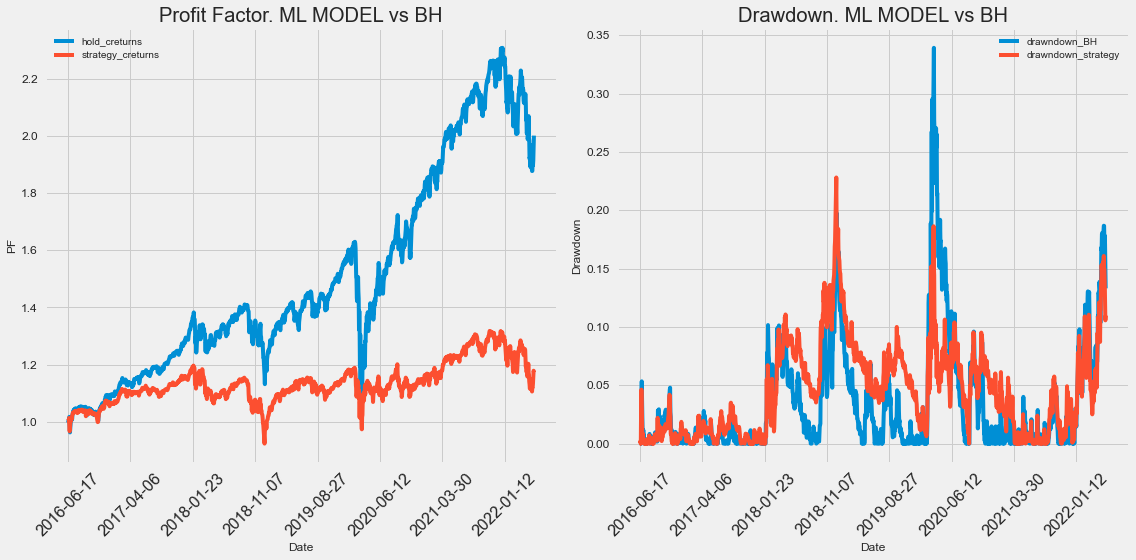

In [124]:
result_mnb = performance_2_class.performance_model(return_daily_BH,y_test,mnb.predict(X_test),return_daily_open_close)

## 4.3.  Logistic Regression (lr) VS buy and hold (BH) <a class="anchor" id="43">

Strategy Performance: 2.039
Hold and Buy Performance: 2.001
Strategy Maximun Drawdown: 0.217
Hold and Buy Drawdown: 0.339


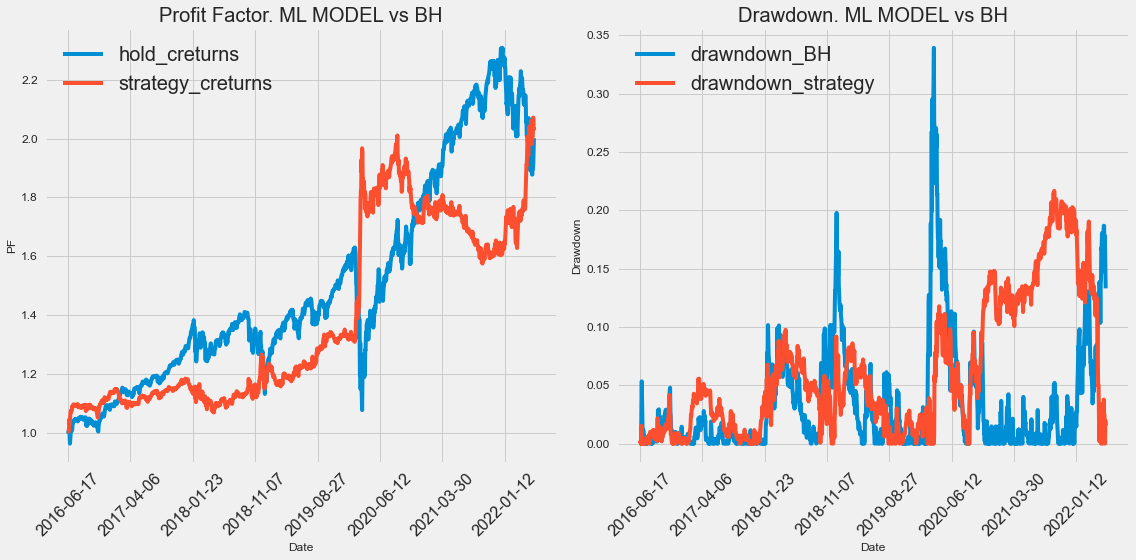

In [125]:
result_lr = performance_2_class.performance_model(return_daily_BH,y_test,lr.predict(X_test),return_daily_open_close)

## 4.4.  K-Nearest Neighboursn (KNN) VS buy and hold (BH) <a class="anchor" id="44">

Strategy Performance: 0.745
Hold and Buy Performance: 2.001
Strategy Maximun Drawdown: 0.449
Hold and Buy Drawdown: 0.339


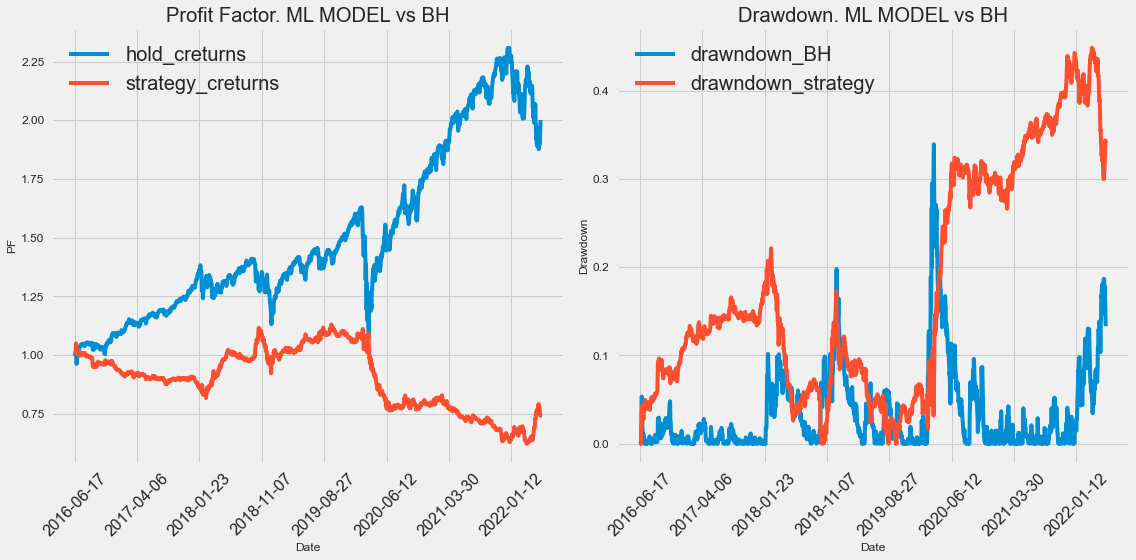

In [126]:
result_knn = performance_2_class.performance_model(return_daily_BH,y_test,knn.predict(X_test),return_daily_open_close)

## 4.5.  Support Vector Machine (SVM) VS buy and hold (BH) <a class="anchor" id="45">

Strategy Performance: 0.961
Hold and Buy Performance: 2.001
Strategy Maximun Drawdown: 0.246
Hold and Buy Drawdown: 0.339


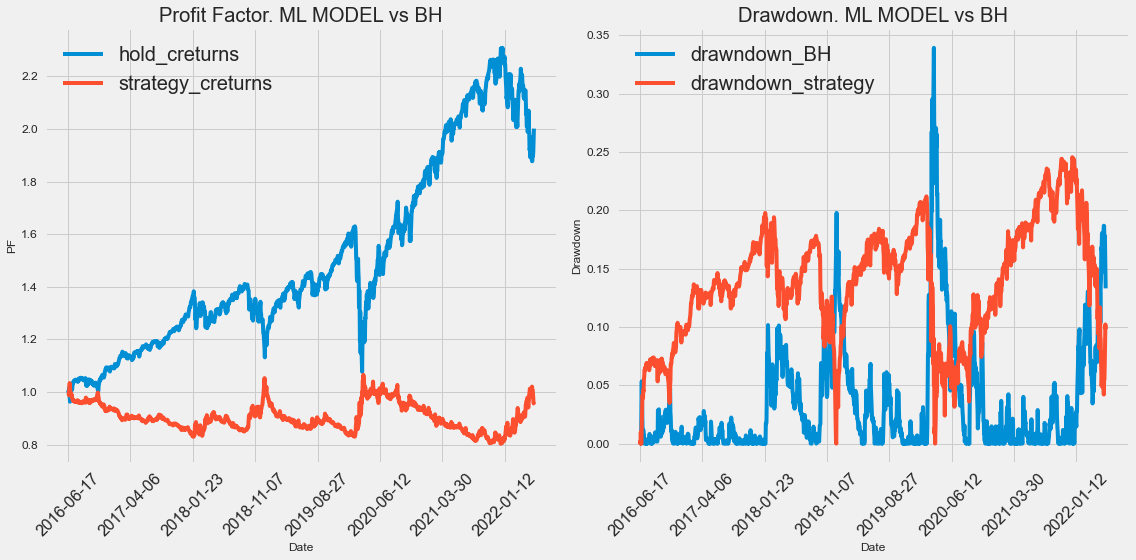

In [127]:
result_svm = performance_2_class.performance_model(return_daily_BH,y_test,svm.predict(X_test),return_daily_open_close)

## 4.6.  Decision Tree Classifier (clf) VS buy and hold (BH) <a class="anchor" id="46">

Strategy Performance: 2.015
Hold and Buy Performance: 2.001
Strategy Maximun Drawdown: 0.24
Hold and Buy Drawdown: 0.339


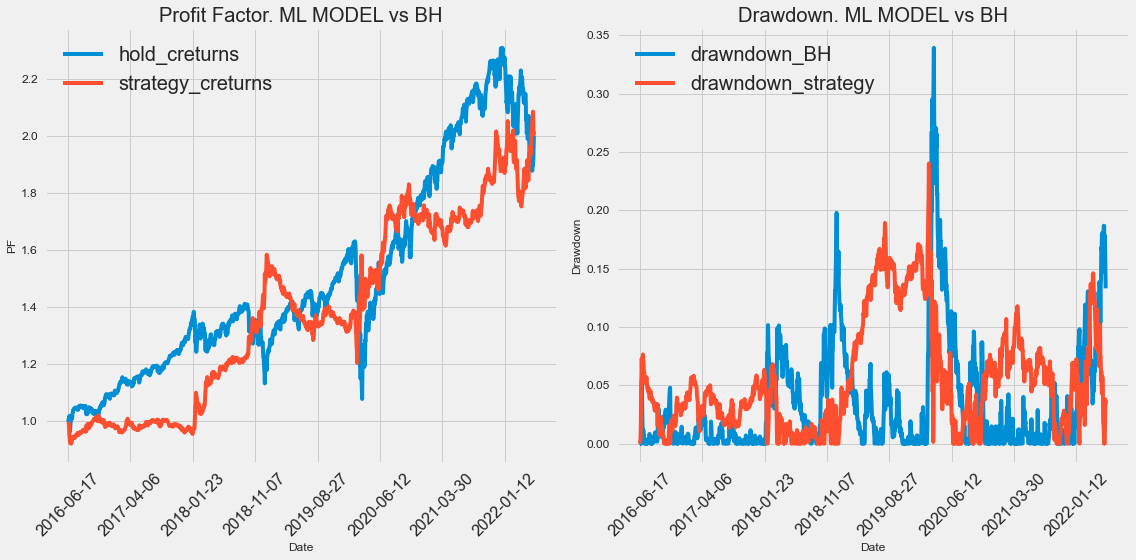

In [128]:
result_clf = performance_2_class.performance_model(return_daily_BH,y_test,clf.predict(X_test),return_daily_open_close)

## 4.7. Bagging Decision Tree (bg) VS buy and hold (BH) <a class="anchor" id="47">

Strategy Performance: 1.151
Hold and Buy Performance: 2.001
Strategy Maximun Drawdown: 0.197
Hold and Buy Drawdown: 0.339


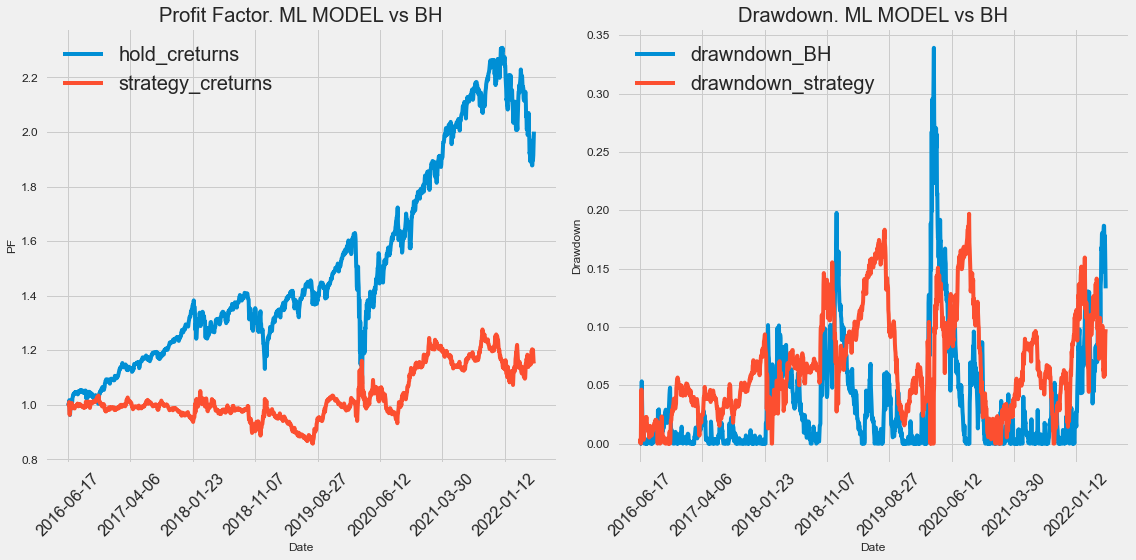

In [129]:
result_bg = performance_2_class.performance_model(return_daily_BH,y_test,bg.predict(X_test),return_daily_open_close)

## 4.8. Boosting Decision Tree (adb) VS buy and hold (BH) <a class="anchor" id="48">

Strategy Performance: 1.782
Hold and Buy Performance: 2.001
Strategy Maximun Drawdown: 0.185
Hold and Buy Drawdown: 0.339


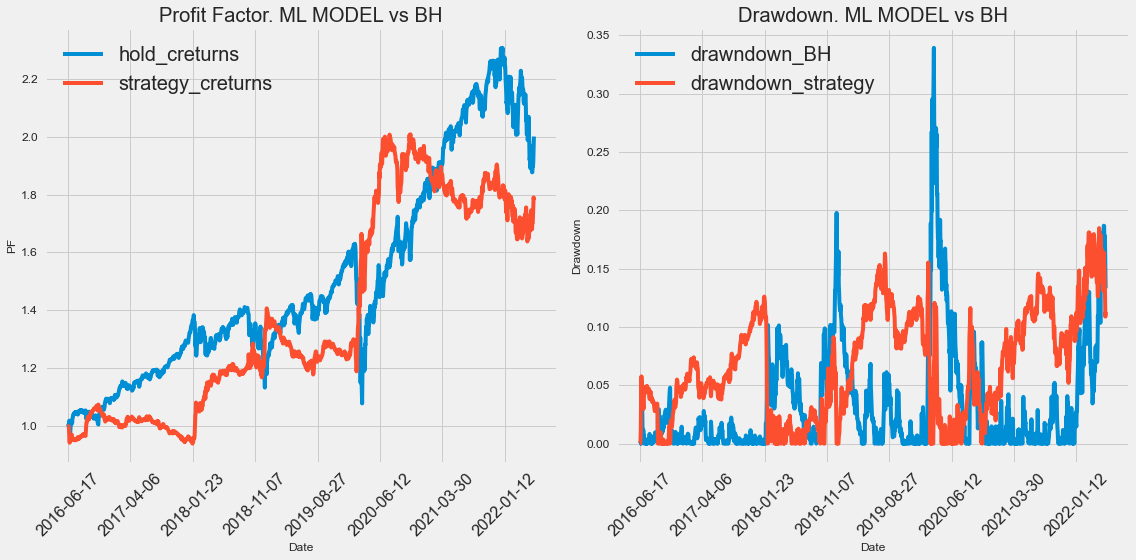

In [130]:
result_adb = performance_2_class.performance_model(return_daily_BH,y_test,adb.predict(X_test),return_daily_open_close)

## 4.9.  Random Forest (rf) VS buy and hold (BH) <a class="anchor" id="49">

Strategy Performance: 1.683
Hold and Buy Performance: 2.001
Strategy Maximun Drawdown: 0.215
Hold and Buy Drawdown: 0.339


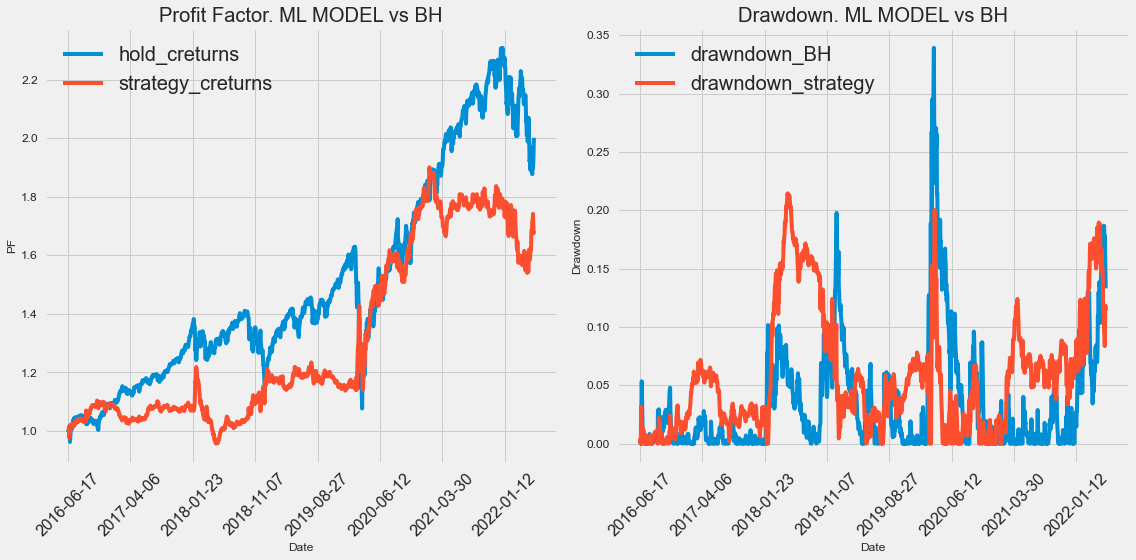

In [131]:
result_rf = performance_2_class.performance_model(return_daily_BH,y_test,rf.predict(X_test),return_daily_open_close)

## 4.10. Ensemble Voting Classifier (EVC) VS buy and hold (BH) <a class="anchor" id="410">

Strategy Performance: 2.403
Hold and Buy Performance: 2.001
Strategy Maximun Drawdown: 0.191
Hold and Buy Drawdown: 0.339


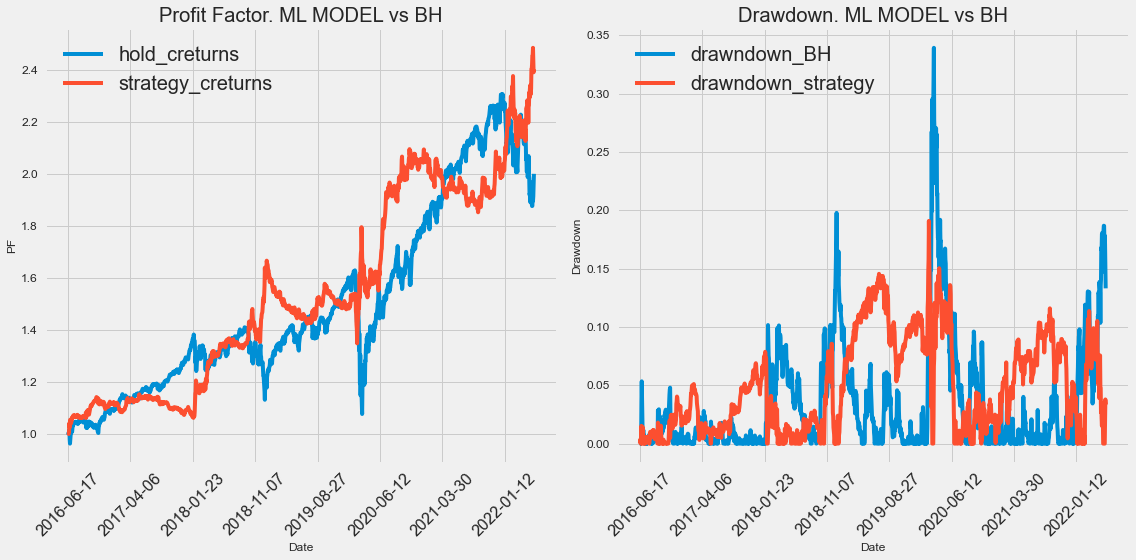

In [132]:
result_evc = performance_2_class.performance_model(return_daily_BH,
                                                   y_test,evc.predict(X_test),return_daily_open_close)

# Annex 1. Saving EVC Performance

In [133]:
from datetime import datetime
from datetime import date
dt = datetime.today()

timestamp =  str(dt.year)+'_'+str(dt.month)+'_'+str(dt.day)+'_'+str(dt.hour)+"_"+str(dt.minute)+"_"+str(dt.second)

save_name = './DATA_MODELS/EVC_' + timestamp+ ".csv"

result_evc.to_csv(save_name, encoding='utf-8')

# Annex 2. Saving Notebook Simulation

In [134]:
from IPython.display import Javascript
from nbconvert import HTMLExporter

def save_notebook():
    display(
        Javascript("IPython.notebook.save_notebook()"),
        include=['application/javascript']
    )

def output_HTML(read_file, output_file):
    import codecs
    import nbformat
    exporter = HTMLExporter()
    # read_file is '.ipynb', output_file is '.html'
    output_notebook = nbformat.read(read_file, as_version=4)
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)

In [135]:
import time
save_notebook()
time.sleep(3)
current_file = 'ML_SP500_Binary_Classification.ipynb'
output_file = './html/'+timestamp + '.html'
output_HTML(current_file, output_file)

In [136]:
# Just to see when the code was run for last time
print(datetime.now())

2023-03-22 21:28:23.737846
